In [1]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.interpolate import interp1d
import pandas as pd
import warnings
import socket
import configparser
import multiprocessing as mp
from brian2 import *
from tqdm.notebook import tqdm

import pyoelectricity as pel

In [2]:
save_plots = True
# Flag for more plots and info
verbose = True

# Experiment

## Parameters

In [3]:
# The nerve is hanging in between electrodes.
# We estimate the effective length to be
electrode_distance = 6 * mm

## Function definitions

### Baseline removal and noise masking

In [4]:
@check_units(U=volt, times=ms, t_pre=ms, t_post=ms)
def make_Mask(U, times, t_pre, t_post):
    """ Generate a boolean mask around the spikes"""
    # To find the maximum we first apply smoothing
    U_raw_smooth = savgol_filter(U, 101, 1, axis=1)
    maxargs = np.int32(savgol_filter(np.nanargmax(U_raw_smooth, axis=1), 3, 1))

    # Mask matrix is filled line by line
    mask = np.ones_like(U, dtype=bool)
    for i, mask_line in enumerate(mask):
        i_t_pre = np.nanargmin(np.abs(times - times[maxargs[i]] + t_pre))
        i_t_post = np.nanargmin(np.abs(times - times[maxargs[i]] - t_post))
        mask_line[i_t_pre:i_t_post] = False

    return mask

# Fit the baseline
@check_units(y=volt, result=volt)
def baseline_als(y, lam, p, niter=10):
    """ Fit baseline for a single trace.
    Parameters: p for asymmetry and lam for smoothness
    From: "Asymmetric Least Squares Smoothing" by P. Eilers and H. Boelens 2005
    https://stackoverflow.com/questions/29156532/python-baseline-correction-library
    """
    my_unit = y.get_best_unit()
    y = y / my_unit
    L = len(y)
    D = sparse.diags([1, -2, 1], [0, -1, -2], shape=(L, L - 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w * y)
        w = p * (y > z) + (1 - p) * (y < z)
    return z * my_unit

@check_units(U=volt, result=volt)
def remove_Base_als(U):
    """Remove the baseline"""
    U_base = np.full_like(U, 0*mV)
    for i, U_lne in enumerate(U):
        U_base[i] = baseline_als(U_lne, 9e12, 0.5)
    return U - U_base

### Spatiotemporal transformations

In [5]:
@check_units(times_raw=ms, delays_raw=ms)
def make_Rel(Data_raw, times_raw, delays_raw):
    """ Transform to symmetric representation"""
    # This function can be used to transorm voltage measurements or boolean masks (which do not have units)
    # The respective units are extracted here and required below
    try:
        my_unit = Data_raw.get_best_unit()
    except AttributeError:
        my_unit = 1.0
    
    raw_dt = np.diff(times_raw)[0]
    delay_step = np.diff(delays_raw)[0]  # Delay step [ms]
    delay_step_i = int(
        np.round(0.5 * delay_step / (times_raw[1] - times_raw[0])))  #

    # Create empty Array for relative data
    total_ix, total_iy = Data_raw.shape
    rel_total_iy = (total_ix - 1) * delay_step_i + total_iy
    Data_rel = np.full((total_ix, rel_total_iy), np.nan)*my_unit

    # Fill relative data
    for i, line_raw in enumerate(Data_raw):
        Data_rel[i, (total_ix - i - 1) * delay_step_i:rel_total_iy -
          i * delay_step_i] = line_raw

    # Create time array
    Tend = (np.max(times_raw) - np.min(times_raw)) / \
        len(times_raw) * Data_rel.shape[1]
    new_times = np.linspace(0, Tend, Data_rel.shape[1])
    
    # Create time array
    Tend = (max(times_raw)/ms - min(times_raw)/ms) / \
        len(times_raw) * Data_rel.shape[1] * ms
    
    new_times = np.linspace(0, Tend/ms, Data_rel.shape[1])*ms
    
    i_collision = nanargmax(nanmax(Data_rel, 1))
    new_times -= new_times[nanargmax(Data_rel[i_collision])]

    return Data_rel, new_times

@check_units(U=mV, delays_raw=ms, result=ms)
def get_rel_delays(U, delays_raw, debug_flag=False):
    """Find the center of the collision"""

    def gaussian_fun(x, a, x0, dx, a0):
        return a0 + a * np.exp(-0.5 * ((x - x0) / (dx))**2)

    peaks_x = np.nanmax(U, 1)
    ix_collision = np.argmax(peaks_x) # initial value
    popt, pcov = curve_fit(gaussian_fun,
                           delays_raw/ms,
                           peaks_x/mV,
                           p0=[2.5, delays_raw[ix_collision]/ms, 0.2, 3.0])
    a = popt[0]*mV
    x0 = popt[1]*ms
    dx = popt[2]*ms
    a0 = popt[3]*mV
    delays_rel = delays_raw - x0

    if debug_flag:
        xs = np.linspace(np.min(delays_raw/ms), np.max(delays_raw/ms), 200)*ms
        plt.figure("Find peak")
        plt.plot(xs/ms, gaussian_fun(xs, a, x0, dx, a0)/mV, alpha=0.5)
        plt.axvline(popt[1])
        plt.plot(delays_raw / ms, np.max(U, axis=1) / mV, "+")
        
    return delays_rel

### Calculation of the discharge

In [6]:
@check_units(U=volt, times_raw=ms, delays=ms,positions=mm,result=mV*ms/mm**2)
def calc_Psi_exp(U, times_raw, delays, positions, ddu_smooth=False, debug_flag=False):
    
    sym_U, sym_T = make_Rel(U, times_raw, delays)
    sym_U = savgol_filter(sym_U/mV, 3, 1, axis=0)*mV
    
    m_dt = np.abs(np.diff(times_raw)[0])
    m_ds = np.abs(np.diff(positions)[0])

    dU = np.gradient(sym_U, axis=0)
    ddU = np.gradient(dU, axis=0)
    if ddu_smooth:
        ddU = savgol_filter(ddU/mV, 3, 1, axis=0)*mV

    sig_mask = make_Mask(
        U, times_raw, t_pre=0.4*ms, t_post=1.0*ms)
    sig_mask_rel, t_rel = make_Rel(sig_mask, times_raw, delays)

    mskd_mV = np.ma.masked_where(sig_mask_rel, ddU/mV)
    Psi_mskd_mV = np.sum(mskd_mV, axis=1)
    Psi = np.array(Psi_mskd_mV)*mV*m_dt/m_ds**2
    #assert Psi.has_same_dimensions(mV*ms/mm**2)

    if debug_flag:
        fig, axs = plt.subplots(1, 3, figsize=(14, 3))
        axs[0].imshow(U/mV, aspect='auto', interpolation='none')
        axs[1].imshow(mskd_mV, aspect='auto', interpolation='none')
        axs[2].plot(Psi/(mV*ms/mm**2))
    
    return Psi

## Load data
We load four recordings from 3 electrodes each.

In [7]:
datapath = '/mnt/c/Users/ms/Documents/data/17-08-15/'
print(datapath)

/mnt/c/Users/ms/Documents/data/17-08-15/


In [8]:
def load_exp_data(i_files, channels):
    data = {}
    for i_file in i_files:
        for channel in channels:
            id_str = str(i_file) + channel
            print(id_str, ":", end="")
            # npz_file = np.load("/home/mo/data/17-08-15/ret%04i.npz" % i_file)
            npz_file = np.load(datapath+"ret%04i.npz" % i_file)

            U_raw = savgol_filter(npz_file[channel], 51, 1, axis=1) * mV
            times_raw = npz_file['T' + channel] * second
            delays_raw = npz_file["delays"] * ms
            U = remove_Base_als(U_raw)
            
            print(U.shape, end=".  ")

            recording = {
                "id_str": id_str,
                "U": U,
                "U_raw": U_raw,
                "times_raw": times_raw,
                "delays_raw": delays_raw,
            }
            data[id_str] = recording

    return data

In [9]:
# Load data
i_files=[18, 19, 20] #, 21]
channels=["C1", "C2", "C3"]
data = load_exp_data(i_files, channels)

18C1 :(21, 10002).  18C2 :(21, 10002).  18C3 :(21, 10002).  19C1 :(21, 10002).  19C2 :(21, 10002).  19C3 :(21, 10002).  20C1 :(46, 10002).  20C2 :(46, 10002).  20C3 :(46, 10002).  

In [10]:
data['18C2'].keys()

dict_keys(['id_str', 'U', 'U_raw', 'times_raw', 'delays_raw'])

In [11]:
for i in i_files:
    print(i)
    d = data['%iC2'%i]
    for qstr in[ "times_raw", "delays_raw" ]:
        q = d[qstr]
        q_rng = q[-1] - q[0]
        print("%20s"%qstr, "%5i"%len(q), "%12s"%q_rng.in_best_unit(2),# "%12s"%q[-1].in_best_unit(2),
              ' step: ', "%12s"%(q[1]-q[0]).in_best_unit(2), ' rate: ', (1/(q[1]-q[0])).in_best_unit(2))

18
           times_raw 10002       10. ms  step:         1. us  rate:  1. MHz
          delays_raw    21        4. ms  step:       200. us  rate:  5. kHz
19
           times_raw 10002       10. ms  step:         1. us  rate:  1. MHz
          delays_raw    21      4.54 ms  step:       227. us  rate:  4.41 kHz
20
           times_raw 10002       10. ms  step:         1. us  rate:  1. MHz
          delays_raw    46       4.5 ms  step:       100. us  rate:  10. kHz


In [12]:
for qstr in[ "times_raw", "delays_raw" ]:
    print(qstr)
    for i in i_files:
#        print(i)
        d = data['%iC2'%i]
        q = d[qstr]
        q_rng = q[-1] - q[0]
        print("%20s"%qstr, "%5i"%len(q), "%12s"%q_rng.in_best_unit(2),
              ' step: ', "%12s"%(q[1]-q[0]).in_best_unit(2), ' rate: ', (1/(q[1]-q[0])).in_best_unit(2))

times_raw
           times_raw 10002       10. ms  step:         1. us  rate:  1. MHz
           times_raw 10002       10. ms  step:         1. us  rate:  1. MHz
           times_raw 10002       10. ms  step:         1. us  rate:  1. MHz
delays_raw
          delays_raw    21        4. ms  step:       200. us  rate:  5. kHz
          delays_raw    21      4.54 ms  step:       227. us  rate:  4.41 kHz
          delays_raw    46       4.5 ms  step:       100. us  rate:  10. kHz


-3.42  4.90
-3.71  5.48
-3.68  5.27


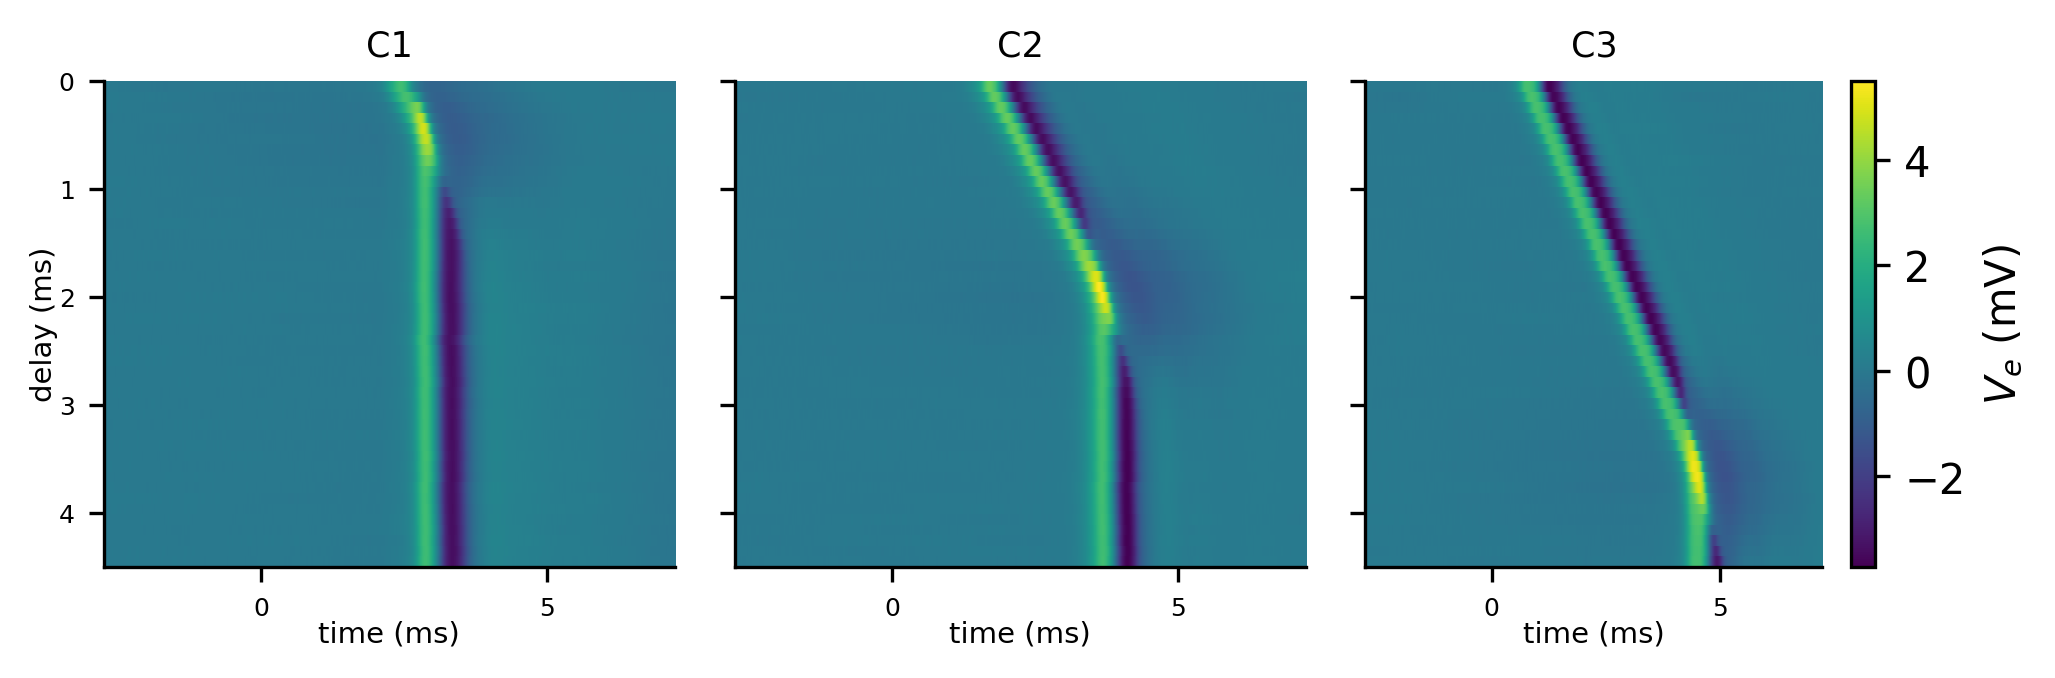

In [13]:
with plt.style.context('plot_style.txt'):
    cm_inch = 1/2.54 # 11.4 or 17.8
    fig, axs = plt.subplots(1, 3, figsize=(17.8*cm_inch, 6*cm_inch), sharey='row')
    # fig, axs = plt.subplots(1,3, figsize=(12, 4), sharex=True, sharey='row')
    for i, i_file in enumerate([i_files[-1]]):
        for j, channel in enumerate(channels):
            dat = data["%i%s"%(i_file, channel)]#['U']
            extent = [dat['times_raw'].min()/ms,
                      dat['times_raw'].max()/ms,
                      dat['delays_raw'].max()/ms,
                      dat['delays_raw'].min()/ms]
            im = axs[j].imshow(dat['U']/mV,
                               aspect='auto',
                               interpolation='none',
                               extent=extent,
                               vmin=-3.71, vmax=5.48)
            print('%5.2f %5.2f'%(np.min(dat['U']/mV), np.max(dat['U']/mV)))
            axs[j].set_title(channel)
    axs[0].set_ylabel('delay (ms)')
    [ax.set_xlabel('time (ms)') for ax in axs]

fig.colorbar(im, label='$V_e$ (mV)')
plt.tight_layout()
plt.savefig('SI-exp-raw.pdf')

In [14]:
#e_dist = (0.5 * np.diff([0.4, 1.9, 3.6]*ms))*v_mean
#e_dist.in_best_unit(2)

## Calculate velocity

Recording sites are seperated by one earth electrode, the effective length between recording points is then 12mm. The velocity is calculated from the AP arrival time at different electrodes. There are four recording from 3 sites respectively. That makes two velocities for each direction and recording. When the Collision is occuring between the recording sites, than the velocity is somwhat corrupted, which gives a very large (possibly almost infinite) velocity.

In [15]:
def calc_exp_velocity(data, i_files, channels, make_plots=False):
    v_s = {}
    
    if make_plots:
        fig, axs = plt.subplots(1, len(i_files), figsize=(14,4))
        
    for i, i_file in enumerate(np.array(i_files, dtype=str)):
        # Get arrival times of the positive peak
        for channel in channels:
            id_str = str(i_file) + channel
            u = savgol_filter(data[id_str]["U"], 101, 1)
            t = data[id_str]["times_raw"]
            data[id_str]["arrival_times"] = t[np.argmax(u, axis=1)]

        # Calculate velocities
        dist = 2*electrode_distance
        v12 = dist / np.abs(data[i_file + "C1"]["arrival_times"] -
                           data[i_file + "C2"]["arrival_times"])
        v23 = dist / np.abs(data[i_file + "C2"]["arrival_times"] -
                           data[i_file + "C3"]["arrival_times"])

        # Check for correct units 
        for v in [v12, v23]:#, v13]:
            assert v.has_same_dimensions(mm/ms)

        # Only the first and last two values are stored (see figures)
        v_s[i_file] = np.ravel([np.ravel([v[:2], v[-2:]]) for v in [v12, v23]]) 

        if make_plots:
            axs[i].plot(data[id_str]["delays_raw"]/ms, v12/(mm/ms), label="v12")
            axs[i].plot(data[id_str]["delays_raw"]/ms, v23/(mm/ms), label="v23")
            axs[i].set_title(i_file)
            axs[i].set_ylabel("$v_p$ (m/s)")
            axs[i].set_xlabel("delay (ms)")
            axs[i].set_ylim(10,30)
            axs[i].legend()
            
    if make_plots:
        plt.tight_layout()
        
    vs = pd.DataFrame(
        v_s, index=["1>2", "1>2", "1<2", "1<2", "2>3", "2>3", "2<3", "2<3"])
    v_mean = vs.stack().mean()*mm/ms
    return v_mean, vs

In [16]:
# Calculate all velocities
v_mean, vs = calc_exp_velocity(data, i_files, channels, make_plots=True)
pd.options.display.float_format = '{:,.1f}'.format
#print("per recording:")
#print(vs.mean(0))
print("overall velocity v_p:  %2.1f +- %2.1f m/s" % (v_mean, vs.stack().std()))
vs.plot();

overall velocity v_p:  14.5 +- 1.1 m/s


In [17]:
vs

,18,19,20
1>2,16.2,16.2,16.3
1>2,15.0,15.2,16.2
1<2,15.1,15.1,14.9
1<2,15.0,15.1,14.9
2>3,13.1,13.1,13.3
2>3,13.2,13.1,13.4
2<3,13.0,14.3,14.5
2<3,13.1,14.6,14.8


In [18]:
a = vs.style.to_latex()
for i in a.split('\n'):
    print(i)

\begin{tabular}{lrrr}
 & 18 & 19 & 20 \\
1>2 & 16.150740 & 16.194332 & 16.348774 \\
1>2 & 15.037594 & 15.151515 & 16.216216 \\
1<2 & 15.094340 & 15.132409 & 14.888337 \\
1<2 & 15.037594 & 15.075377 & 14.869888 \\
2>3 & 13.114797 & 13.100480 & 13.259683 \\
2>3 & 13.172338 & 13.100437 & 13.422834 \\
2<3 & 12.958963 & 14.251781 & 14.492754 \\
2<3 & 13.143483 & 14.616322 & 14.778325 \\
\end{tabular}



In [19]:
ortho = vs.loc[['1<2', '2<3']]
print('orthodromic:', np.ravel(ortho).mean(), np.ravel(ortho).std())

anti = vs.loc[['1>2', '2>3']]
print('antidromic:', np.ravel(anti).mean(), np.ravel(anti).std())

allv = vs#.loc[['1>2', '2>3']]
print('total:', np.ravel(allv).mean(), np.ravel(allv).std())

orthodromic: 14.528297757992881 0.7082168547649633
antidromic: 14.52247832021231 1.3833553410713368
total: 14.525388039102594 1.098922209706359


In [20]:
v_mean.in_best_unit(2)

'14.53 mm/ms'

## Calculate PSI

point of collision, relative distances and PSI

In [21]:
for id_str, recording in data.items():
    recording["delays_rel"] = get_rel_delays(recording["U"],
                                             recording["delays_raw"])
    recording["positions"] = 0.5 * v_mean * recording["delays_rel"]
    recording["Psi"] = calc_Psi_exp(recording["U"],
                            recording["times_raw"],
                            recording["delays_rel"],
                            recording["positions"],
                            debug_flag=True,
                            ddu_smooth=False)

In [22]:
# Full raw measurement and transformed view
if verbose:
    fig, axs = plt.subplots(1,2,figsize=(15,5))

    id_str = '20C2'
    recording = data[id_str]
    extent = [
            min(recording['times_raw'])/ms,
            max(recording['times_raw'])/ms,
            max(recording['delays_raw'])/ms,
            min(recording['delays_raw'])/ms,
    ]
    axs[0].imshow(recording["U"]/mV, aspect='auto', interpolation='none', extent=extent)

    U_rel, times_rel = make_Rel(data[id_str]["U"], data[id_str]["times_raw"],
                                data[id_str]["delays_raw"])
    extent = [
            min(times_rel)/ms,
            max(times_rel)/ms,
            max(recording['delays_rel'])/ms,
            min(recording['delays_rel'])/ms,
    ]
    axs[1].imshow(U_rel/mV, aspect='auto', interpolation='none', extent=extent)
    for ax in axs:
        ax.set_ylabel("delay (ms)")
        ax.set_xlabel("time (ms)")

## Plot AP traces

The raw experimental results. First the traces of $V_e$ are plotted for propagating and collisding APs.

In [23]:
def plt_i_aligned(ax, t, u, n_smooth=41, **kwargs):
    u_smooth = savgol_filter(u/mV, n_smooth, 1)*mV
    i_peak = nanargmax(u_smooth)
    t_plot = t - t[i_peak]
    is_baseline = (-2*ms<t_plot)&(t_plot<-1*ms)
    if sum(is_baseline)>3:
        offset = mean(u_smooth[is_baseline])
        u_smooth -= offset
    assert u_smooth.has_same_dimensions(mV)
    assert t_plot.has_same_dimensions(ms)
    return ax.plot(t_plot / ms, u_smooth / mV, **kwargs)
    
def plot_exp_traces(axs, **kwargs):
    for i_file in [18,19,20]:#,21]:#i_files[-1]:
        for ax in axs:
            ax.set_prop_cycle(None)
        
        id_str = f'{i_file}C%i'%1 # anterior (near head) 
        experiment = data[id_str]
        U_rel, times_rel = make_Rel(experiment["U"], experiment["times_raw"],
                                    experiment["delays_raw"])
        i_coll = np.argmin(np.abs(experiment['delays_rel']))
        ln = plt_i_aligned(axs[0], times_rel, U_rel[-1], **kwargs)
        plt_i_aligned(axs[1], times_rel, U_rel[i_coll], **kwargs)

        id_str = f'{i_file}C%i'%2 # medial
        experiment = data[id_str]
        U_rel, times_rel = make_Rel(experiment["U"], experiment["times_raw"],
                                    experiment["delays_raw"])
        i_coll = np.argmin(np.abs(experiment['delays_rel']))
        ln = plt_i_aligned(axs[0], times_rel, U_rel[-1], **kwargs)
        plt_i_aligned(axs[1], times_rel, U_rel[i_coll], **kwargs)

        id_str = f'{i_file}C%i'%3 # posterior 
        experiment = data[id_str]
        U_rel, times_rel = make_Rel(experiment["U"], experiment["times_raw"],
                                    experiment["delays_raw"])
        i_coll = np.argmin(np.abs(experiment['delays_rel']))
        ln = plt_i_aligned(axs[0], times_rel, U_rel[1], **kwargs)
        plt_i_aligned(axs[1], times_rel, U_rel[i_coll], **kwargs)
        
    axs[0].set_ylabel("$V_e$ (mV)")
    axs[1].set_ylabel("$V_e$ (mV)")
    axs[1].set_xlabel("time (ms)")
    axs[0].set_xlim(-1, 3)
    axs[1].set_xlim(-1, 3)
    
    axs[0].set_xlim(-.5, 1.5)
    axs[1].set_xlim(-.5, 1.5)

if verbose:
    fig, axs = plt.subplots(1,2, figsize=(15, 4))
    plot_exp_traces(axs, color='gray')

## Plot spatial profile

Then the maximal and minimal values are plotted as a funcxtion of the distance to the collision.

In [24]:
# Plot and calculation
def plot_exp_spatial(axs, **kwargs):
    grad_widths = []
    #pos_fwhm = []
    #prop_peaks = []
    #coll_peaks = []
    for id_str in data.keys():
        positions_mm = data[id_str]["positions"] / mm
        assert is_dimensionless(positions_mm)

        U_min = data[id_str]["U"].min(1) / mV
        assert is_dimensionless(U_min)
        axs[0].plot(positions_mm, U_min, **kwargs)
        axs[0].set_ylabel("Umin (mV)")

        U_max = data[id_str]["U"].max(1) / mV
        assert is_dimensionless(U_max)
        axs[1].plot(positions_mm, U_max, **kwargs)
        axs[1].set_ylabel("Umax (mV)")

        Psi_tesla = data[id_str]["Psi"] / (mV*ms/mm**2)
        assert is_dimensionless(Psi_tesla)
        axs[2].plot(positions_mm, Psi_tesla, **kwargs)
        axs[2].set_ylabel("Psi (T)")
        
        if id_str.endswith("C2"):
            dU_min = np.gradient(U_min)
            grad_widths.append(positions_mm[argmin(dU_min)] - positions_mm[argmax(dU_min)])
            s_width = positions_mm[argmin(dU_min)] - positions_mm[argmax(dU_min)]
            print(id_str, '& %5.1f mm'%s_width)
            #prop_peaks.append([U_max[0]*mV, U_max[-1]*mV])
            #coll_peaks.append(max(U_max)*mV)
            
        if 0:
            plt.figure('off')
            ln = plt.plot(positions_mm, U_max, 'o')
            HD_pos = np.linspace(min(positions_mm), max(positions_mm), num=200) 
            HD_U_max_fun = interp1d(positions_mm, U_max, kind='cubic')
            HD_U_max = HD_U_max_fun(HD_pos)
            
            half_max = (max(HD_U_max) + min(HD_U_max))/2
            width_off = (HD_U_max-half_max)
            
            plt.plot(HD_pos, width_off, '--', color=ln[0].get_color())
            side1 = (HD_pos>0)
            p1 = HD_pos[side1][argmin(abs(width_off[side1]))]
            side2 = (HD_pos<0)
            p2 = HD_pos[side2][argmin(abs(width_off[side2]))]
            
            pos_fwhm.append(p1-p2)
            
            
    #pos_fwhm = (array(pos_fwhm))*mm
    #print("PositivePeakWidth: ",mean(pos_fwhm/2), std(pos_fwhm)/2)
    
    grad_widths = (array(grad_widths))*mm
    
    plt.tight_layout()
    gradwidth_exp = mean(abs(grad_widths))
    axs[0].axvline(gradwidth_exp/2/mm, ls="--", color="grey")
    axs[0].axvline(-gradwidth_exp/2/mm, ls="--", color="grey")
    return grad_widths#, array(prop_peaks/mV)*mV, array(prop_peaks/mV)*mV
        
# Gradient width analysis
plt.figure("offs")
plt.clf()
fig, axs = plt.subplots(1,3, figsize=(15,4), num="123")
collision_widths = plot_exp_spatial(axs)    
collision_width_exp = mean(collision_widths)
#prop_peak_exp = prop_peaks.mean()
print("Collision width experiment: %1.2f +- %1.2f mm"%(collision_width_exp/mm, std(collision_widths)/mm))
#print("Prop peak amplitude experiment: %1.2f +- %1.2f mV"%(prop_peak_exp/mV, std(prop_peaks/mV)))
#collision_width_exp = 11.77 * mm

18C2 &  10.2 mm
19C2 &   9.9 mm
20C2 &   8.7 mm
Collision width experiment: 9.59 +- 0.63 mm


## Fig 2: AP and peak profile (width of Collision)

In [25]:
# Plots

with plt.style.context('plot_style.txt'):
    cm_inch = 1/2.54 # 11.4 or 17.8
    fig, axs = plt.subplots(1, 2, figsize=(17.8*cm_inch, 5*cm_inch), gridspec_kw={'width_ratios':[0.6,0.4]})

    id_str = "20C2"
    U_rel, times_rel = make_Rel(data[id_str]["U"], data[id_str]["times_raw"],
                                data[id_str]["delays_raw"])

    i_coll = np.argmin(np.abs(data[id_str]['delays_rel']))

    # find the maximal delay that is availible for both, posterior and anterior stimulation
    d_min = min(data['20C2']['delays_rel'])
    d_max = max(data['20C2']['delays_rel'])
    d_both = min(abs(array([d_min/ms, d_max/ms]))*ms)
    i_prop = np.argmin(np.abs(data[id_str]['delays_rel'] - d_both))
    i_prop2 = np.argmin(np.abs(data[id_str]['delays_rel'] + d_both))

    # Y Axis as position
    extent = [
        np.min(times_rel / ms),
        np.max(times_rel / ms),
        np.max(data[id_str]['positions']) / mm,
        np.min(data[id_str]['positions']) / mm,
    ]
    axs[0].set_ylabel("position (mm)")
    axs[0].set_ylim(-14, 14)

    im = axs[0].imshow(U_rel / mV, extent=extent, aspect="auto", interpolation="none")
    #cbar = plt.colorbar(im, ax=axs[0], label="$V_e$ (mV)", pad=0.0, fraction=0.4)#, location='top')
    cbar = plt.colorbar(im, ax=axs[0], label="$V_e$ (mV)", pad=0.01, fraction=0.3)#, location='top')

    axs[0].set_xlabel("time (ms)")
    axs[0].set_xlim(-1.3, 1.3)

    pos_fwhm = []
    prop_peaks = []
    coll_peaks = []
    for id_str in data.keys():
        positions_mm = data[id_str]["positions"] / mm
        assert is_dimensionless(positions_mm)

        U_max = data[id_str]["U"].max(1) / mV
        assert is_dimensionless(U_max)

        if id_str.endswith("C1"):
            ln = axs[1].plot(positions_mm, U_max, '1', color='black')
        elif id_str.endswith("C2"):              
            ln = axs[1].plot(positions_mm, U_max, '+', color='black')
        else:                                    
            ln = axs[1].plot(positions_mm, U_max, '2', color='black')

        HD_pos = np.linspace(min(positions_mm), max(positions_mm), num=200) 
        HD_U_max_fun = interp1d(positions_mm, U_max, kind='cubic')
        HD_U_max = HD_U_max_fun(HD_pos)
        axs[1].plot(HD_pos, HD_U_max, color=ln[0].get_color(), lw=0.5, alpha=0.5)


        half_max = (max(HD_U_max) + min(HD_U_max))/2
        width_off = (HD_U_max-half_max)
        side1 = (HD_pos>0)
        p1 = HD_pos[side1][argmin(abs(width_off[side1]))]
        side2 = (HD_pos<0)
        p2 = HD_pos[side2][argmin(abs(width_off[side2]))]

        pos_fwhm.append((p1-p2)*mm)

        prop_peaks.append([U_max[0]*mV, U_max[-1]*mV])
        coll_peaks.append(max(U_max)*mV)

    pos_fwhm = array(pos_fwhm/mm)*mm
    prop_peaks= array(prop_peaks/mV)*mV
    coll_peaks= array(coll_peaks/mV)*mV

    line_patch1 = mpatches.mlines.Line2D([None], [None], color='black', ls="", marker="1", label='C1')
    line_patch2 = mpatches.mlines.Line2D([None], [None], color='black', ls="", marker="+", label='C2')
    line_patch3 = mpatches.mlines.Line2D([None], [None], color='black', ls="", marker="2", label='C3')
    axs[1].legend(handles=[line_patch1, line_patch2, line_patch3])

    axs[1].set_ylabel("peak $V_e$ (mV)")
    axs[1].set_xlabel("position (mm)")
    axs[1].set_xlim(-10,10)
    
    axs[0].spines.right.set_visible(True)
    axs[0].spines.top.set_visible(True)

    plt.tight_layout(w_pad=0)
    for ax, l in zip(axs, ['C A B', 'D']):
        X = ax.get_position().x0
        Y = 0.87#ax.get_position().y1
        #print(X, Y)
        ax.annotate(l, fontsize=8,family = 'sans-serif', weight = 'bold',
                    xycoords="subfigure fraction", 
                    xy=(X-0.06, Y)) 
    if save_plots:
        fig.savefig("Fig2-CD.svg")
        fig.savefig("Fig2-CD.pdf")

In [26]:
# Print numerical values
# Propagation peak amplitude
print("Propagation peak: ", prop_peaks.mean().in_unit(mV, 2), prop_peaks.std().in_unit(mV, 2)) # 2.8mV
# Collision peak amplitude
print("  Collision peak: ", coll_peaks.mean().in_unit(mV, 2), coll_peaks.std().in_unit(mV, 2)) #5.1mV

# Consequent amplification
amplification = coll_peaks/prop_peaks.mean(1)
print(f"   Amplification:  {amplification.mean():1.2f} +- {amplification.std():1.2f}")

# Width of the peak amplification around the collision
print(f"           Width:  {pos_fwhm.mean().in_unit(mm, 2)} +- {pos_fwhm.std().in_unit(mm, 2)}")

Propagation peak:  2.85 mV 0.23 mV
  Collision peak:  5.23 mV 0.26 mV
   Amplification:  1.84 +- 0.05
           Width:  3.82 mm +- 0.47 mm


# Simulation

In [27]:
1/(40 * ohm *cm**2)

250. * metre ** -4 * kilogram ** -1 * second ** 3 * amp ** 2

In [28]:
# used in all models
pde_integration_method = 'rk4'

morpho_MGF = Cylinder(x=Quantity([0*cm, 10*cm]), diameter=80 * um, n=2001)

## Function definitions

In [29]:
def calculate_Ve_Collision(M,
                           t_start=0 * ms,
                           t_stop=28 * ms,
                           el_geometry = 'EL',
                           electrode_distance = np.nan*mm,
                           electrode_radius=0.4*mm,
                           electrode_separation = electrode_distance,
                           prop_peak_set=prop_peaks.mean()
                          ):
    """Calculates Ve at one side of the collision and returns mirrored (len=2*Ne) x, t, V_e"""
    
    # Anti Aliasing the target positions with respect to the source
    x_source = M.source.morphology.x
    ix_start = argmin(abs(x_source-1*cm))
    ix_stop = x_source.shape[0]//2
    #x_target = x_source[ix_start:ix_stop+1:10]
    x_target = x_source[ix_start:ix_stop+1]
    center_source = (x_source.max()+x_source.min())/2
    assert x_target.max()==center_source
    
    # Define positions at which V_e is calculated
    target = NeuronGroup(x_target.shape[0],
                         model=''' x : meter
                                   y : meter
                                   z : meter''')

    target.x = x_target#np.linspace(1, 5, Ne) * cm
    target.y = electrode_distance
    target.z = 0 * mm

    # Run the V_e calculation
    t_es, V_es = pel.calculate_V_e_Parallel(M,
                                            target,
                                            t_start=t_start,
                                            t_stop=t_stop,
                                            el_geometry=el_geometry,
                                            electrode_radius=electrode_radius,
                                            electrode_separation=electrode_separation)

    # Save numerical efford by mirroring Ve
    # Extracellular potential is calculated only at one side of the collision
    # This mirrors the result to provide the full image
    V_es_full = np.vstack([V_es / mV, V_es[-2::-1, :] / mV]) * mV
    
    if prop_peak_set is None:
        scaling_f = 1.0
    else:
        #Scale to given peak of propagating AP
        max_vals = V_es.max(axis=1)
        prop_peak = max_vals[len(max_vals) // 2]
        scaling_f = prop_peak_set / prop_peak
        print(f'raw propagation Peak: {prop_peak/mV:5.1f}mV, now scaled by factor: {scaling_f:4.2f}')
        V_es_full = V_es_full * scaling_f

    # The positions at which V_e is calculated are also mirrored
    target_xs = hstack([
        target.x / mm, 2 * target.x[-1] / mm - target.x[-2::-1] / mm
    ]) * mm - max(target.x)

    return target_xs, t_es, V_es_full, scaling_f

In [30]:
# Functions that tweak the parameters

# Calculate the Width of the Simulation
def get_Width_Simulation(xs_C, t_C, Ve_C):
    U_min = Ve_C.min(axis=1)
    i_center = argmin(abs(xs_C))
    U_midline = (U_min[i_center] + U_min[i_center//2])/2
    midline_deviation = abs(U_min - U_midline)
    
    ix1 = argmin(midline_deviation[:i_center])
    x1 = xs_C[:i_center][ix1]
    ix2 = argmin(midline_deviation[i_center:])
    x2 = xs_C[i_center:][ix2]
    
    return x2-x1

# Adjust capacity in orter to get the right velocity
def fit_vp_via_cm(velocity_set,
                  make_model,
                  morpho,
                  model_kws,
                  exponent=1.0,
                  max_percentual_deviation=0.9,
                  max_iterations=30,
                  **kwargs):
    
    other_model_kws = model_kws.copy()
    Cm_val = other_model_kws.pop('Cm')

    for ii in range(max_iterations):
        neuron = make_model(morpho=morpho, Cm=Cm_val, **other_model_kws)
        Monitor = pel.run_cable(neuron, report=None, **kwargs)
        v_p, _ = pel.get_velocity(Monitor, make_plots=False)
        percentual_deviation = np.abs(v_p / velocity_set - 1) * 100.0
        del Monitor

        if percentual_deviation < max_percentual_deviation:
            model_kws['Cm'] = Cm_val
            print(
                f'Cm={Cm_val/(msiemens/meter**2):6.3f} mF/m^2  v_set={velocity_set/mm*ms:5.2f} m/s',
                f'  v_is = {v_p/mm*ms:5.3f} m/s  Deviation:{percentual_deviation:5.2f} %')
            break
        else:
            Cm_val_next = Cm_val * (v_p / velocity_set) ** exponent
            print(
                f'Cm={Cm_val/(msiemens/meter**2):6.3f} mF/m^2  v_set={velocity_set/mm*ms:5.2f} m/s',
                f'  v_is = {v_p/mm*ms:5.3f} m/s  Deviation:{percentual_deviation:5.2f} %',
                f'   next Cm : {Cm_val_next/(msiemens/meter**2):6.3f}')
            Cm_val = Cm_val_next 
    else:
        warnings.warn(f"Optimal Cm not found !! (last Cm = {Cm_val/(msiemens/meter**2):6.3f})")
    return Cm_val

# This is not explicitly used 
def fit_v_via_gstar(make_neuron, gstar_initial):
    for ii in range(10):
        #Tasaki_neuron = make_Tasaki_neuron(morpho_Squid, gstar=gstar_initial)
        Tasaki_neuron = make_neuron(morpho=morpho_MGF, gstar=gstar_initial)
        Monitor_Tasaki = run_cable(Tasaki_neuron, report=None)
        v_tasaki = get_velocity(Monitor_Tasaki, make_plots=False)
        #gstar_old = Tasaki_neuron.namespace['gstar']
        percentual_deviation = np.abs(v_tasaki / v_HH - 1) * 100.0
        del Monitor_Tasaki

        print(
            f'gstar={gstar_initial:6.1f}  v_HH={v_HH/mm*ms:2.2f} m/s' +
            f'v_tasaki = {v_tasaki/mm*ms:2.2f} m/s  Deviation:{percentual_deviation:5.2f} %'
        )

        if percentual_deviation < 0.1:
            gstar_optimal = gstar_initial
            print("Converged at g_star = ", gstar_optimal)
            break
        else:
            gstar_initial = (v_HH / v_tasaki)**2 * gstar_initial
    else:
        warnings.warn("Optimal g_star not found !!")
    return gstar_optimal

# Iteratively fit ri and cm
def fit_Ri_Cm(make_model, model_kws, exponent=1):
    for iteration in range(10):
        for d in model_kws:
            try:
                print(' - ', d, model_kws[d].in_best_unit(3)) 
            except AttributeError:
                print(' - ', d, model_kws[d])
        
        model_kws['Cm'] = fit_vp_via_cm(velocity_set=v_mean,
                                        morpho=morpho_MGF,
                                        make_model=make_model,
                                        model_kws=model_kws,
                                        exponent=exponent,
                                        defaultclock_dt=0.001*ms)
        print("Velocity ok at ", model_kws)

        This_MGF = make_model(morpho=morpho_MGF, **model_kws)
        M_collision = pel.run_cable(This_MGF,
                               Collide=True,
                               report=None,
                               defaultclock_dt=0.001 * ms)

        xs_TC, t_TC, Ve_TC, _ = calculate_Ve_Collision(M_collision)#,
                                                    #t_start=0.3 * ms)

        f_TC = collision_width_exp / get_Width_Simulation(xs_TC, t_TC, Ve_TC)

        print("Width mismath:", 1-f_TC)
        del M_collision, xs_TC, t_TC, Ve_TC

        if abs(f_TC - 1) < 0.03:
            print('OK.')
            for d in model_kws:
                try:
                    print(' - ', d, model_kws[d].in_best_unit(3)) 
                except AttributeError:
                    print(' - ', d, model_kws[d])
            return model_kws
        else:
            model_kws['Ri'] = This_MGF.Ri / f_TC**2
            model_kws['Cm'] = This_MGF.Cm[0] * f_TC

## Perform fit

In [31]:
general_collision_kws = {
    'Collide': True,
    'report': None,
    'record_dt': 0.001 * ms,
    'defaultclock_dt': 0.0001 * ms,
    'I_stimulation':20. * uamp,
}

do_fit = True

### Tasaki 30

In [32]:
# Tasaki model

Tasaki_kws = {
    'gstar': 30.0 * siemens / metre ** 2,
    'Ri': 20 * ohm * cmetre,
    'Cm': 0.26 * ufarad / cmetre ** 2}

if do_fit:
    Tasaki_kws = fit_Ri_Cm(pel.make_tasaki_neuron, Tasaki_kws)

# Run final Tasaki model
Tasaki_MGF = pel.make_tasaki_neuron(morpho=morpho_MGF, **Tasaki_kws)
M_Tasaki_collision = pel.run_cable(Tasaki_MGF, **general_collision_kws)

 -  gstar 30. m^-4 kg^-1 s^3 A^2
 -  Ri 0.2 m^3 kg s^-3 A^-2
 -  Cm 0.003 m^-4 kg^-1 s^4 A^2
Theory:     14.90m/s,  1.826mm
Simulation: 14.52m/s,  8.446mm
Cm= 2.600 mF/m^2  v_set=14.53 m/s   v_is = 14.516 m/s  Deviation: 0.07 %
Velocity ok at  {'gstar': 30. * siemens / (meter ** 2), 'Ri': 0.2 * ohm * meter, 'Cm': 0.0026 * farad / (meter ** 2)}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   3.3mV, now scaled by factor: 0.87
Width mismath: 0.020776152982483476
OK.
 -  gstar 30. S/(m^2)
 -  Ri 0.2 ohm m
 -  Cm 0.003 F/(m^2)


In [33]:
v_theo, lamb_theo = pel.get_tasaki_v_lambdastar(Tasaki_MGF)
v_sim, lambda_sim = pel.get_velocity(M_Tasaki_collision)
M_Tasaki_collision.namespace['v_sim'] = v_sim

Theory:     14.90m/s,  1.826mm
Simulation: 14.62m/s,  2.049mm


### Tasaki 450

In [34]:
# Tasaki model
Tasaki450_kws = {
    'gstar': 450 * siemens / meter**2,
    'Ri': 1.3 * ohm * cm,
    'Cm': 39.54e-3 * farad / meter**2
}

if do_fit:
    Tasaki450_kws = fit_Ri_Cm(pel.make_tasaki_neuron, Tasaki450_kws)

# Run final Tasaki model
Tasaki450_MGF = pel.make_tasaki_neuron(morpho=morpho_MGF, **Tasaki450_kws)
M_Tasaki450_collision = pel.run_cable(Tasaki450_MGF, **general_collision_kws)

 -  gstar 450. S/(m^2)
 -  Ri 0.013 ohm m
 -  Cm 0.04 F/(m^2)
Theory:     14.88m/s,  1.849mm
Simulation: 14.53m/s,  8.946mm
Cm=39.540 mF/m^2  v_set=14.53 m/s   v_is = 14.533 m/s  Deviation: 0.05 %
Velocity ok at  {'gstar': 450. * siemens / (meter ** 2), 'Ri': 0.013 * ohm * meter, 'Cm': 0.03954 * farad / (meter ** 2)}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:  49.9mV, now scaled by factor: 0.06
Width mismath: 0.020776152982483476
OK.
 -  gstar 450. S/(m^2)
 -  Ri 0.013 ohm m
 -  Cm 0.04 F/(m^2)


In [35]:
v_sim, la = pel.get_velocity(M_Tasaki450_collision)#, x_start=2 * cm, x_stop=4 * cm)

Theory:     14.88m/s,  1.849mm
Simulation: 14.62m/s,  2.049mm


### Repolarizing

In [36]:
Repol_kws = {
    'gstar': 30. * siemens / (meter ** 2),
    'Ri': 0.37829549 * ohm * meter,
    'Cm': 0.00187738 * farad / (meter ** 2),
    'trelax': 0.5*ms
}

if do_fit:
    Repol_kws = fit_Ri_Cm(pel.make_repolarizing_neuron, Repol_kws)

Repol_MGF = pel.make_repolarizing_neuron(morpho=morpho_MGF, **Repol_kws)
M_Repol_collision = pel.run_cable(Repol_MGF, **general_collision_kws)

 -  gstar 30. S/(m^2)
 -  Ri 0.378 ohm m
 -  Cm 0.002 F/(m^2)
 -  trelax 0.5 ms
Theory:     15.00m/s,  1.328mm
Simulation: 14.63m/s,  12.369mm
Cm= 1.877 mF/m^2  v_set=14.53 m/s   v_is = 14.626 m/s  Deviation: 0.69 %
Velocity ok at  {'gstar': 30. * siemens / (meter ** 2), 'Ri': 0.37829549 * ohm * meter, 'Cm': 0.00187738 * farad / (meter ** 2), 'trelax': 0.5 * msecond}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   2.2mV, now scaled by factor: 1.30
Width mismath: 0.020776152982483476
OK.
 -  gstar 30. S/(m^2)
 -  Ri 0.378 ohm m
 -  Cm 0.002 F/(m^2)
 -  trelax 0.5 ms


In [37]:
Repol_kws_025 = {
    'gstar': 30. * siemens / meter**2,
    'Ri': 0.4504 * ohm * meter,
    'Cm': 1.7 * mfarad / meter**2,
    'trelax': 0.25*ms
}

if do_fit:
    Repol_kws_025 = fit_Ri_Cm(pel.make_repolarizing_neuron, Repol_kws_025)

Repol_MGF_025 = pel.make_repolarizing_neuron(morpho=morpho_MGF, **Repol_kws_025)

M_Repol_collision_025 = pel.run_cable(Repol_MGF_025, **general_collision_kws)

 -  gstar 30. S/(m^2)
 -  Ri 0.45 ohm m
 -  Cm 0.002 F/(m^2)
 -  trelax 250. us
Theory:     15.18m/s,  1.217mm
Simulation: 14.52m/s,  9.370mm
Cm= 1.700 mF/m^2  v_set=14.53 m/s   v_is = 14.520 m/s  Deviation: 0.04 %
Velocity ok at  {'gstar': 30. * siemens / (meter ** 2), 'Ri': 0.4504 * ohm * meter, 'Cm': 0.0017 * farad / (meter ** 2), 'trelax': 250. * usecond}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   1.9mV, now scaled by factor: 1.54
Width mismath: -0.010146705344384221
OK.
 -  gstar 30. S/(m^2)
 -  Ri 0.45 ohm m
 -  Cm 0.002 F/(m^2)
 -  trelax 250. us


In [38]:
# Repol_kws_06 = {
#     'gstar': 30. * siemens / meter**2,
#     'Ri': 0.37829549 * ohm * meter,
#     'Cm': 0.00187738 * farad / (meter ** 2),
#     'trelax': 0.6*ms
# }
# 
# if do_fit:
#     Repol_kws_06 = fit_Ri_Cm(pel.make_repolarizing_neuron, Repol_kws_06)
# 
# Repol_MGF_06 = pel.make_repolarizing_neuron(morpho=morpho_MGF, **Repol_kws_06)
# 
# M_Repol_collision_06 = pel.run_cable(Repol_MGF_06, **general_collision_kws)

In [39]:
Repol_kws_100 = {
    'gstar': 30. * siemens / meter**2,
    'Ri': 0.3145 * ohm * meter,
    'Cm': 0.002082 * farad / meter**2,
    'trelax': 1.00*ms
}

if do_fit:
    Repol_kws_100 = fit_Ri_Cm(pel.make_repolarizing_neuron, Repol_kws_100)

Repol_MGF_100 = pel.make_repolarizing_neuron(morpho=morpho_MGF, **Repol_kws_100)

M_Repol_collision_100 = pel.run_cable(Repol_MGF_100, **general_collision_kws)

 -  gstar 30. S/(m^2)
 -  Ri 0.315 ohm m
 -  Cm 0.002 F/(m^2)
 -  trelax 1. ms
Theory:     14.83m/s,  1.456mm
Simulation: 14.52m/s,  6.397mm
Cm= 2.082 mF/m^2  v_set=14.53 m/s   v_is = 14.524 m/s  Deviation: 0.01 %
Velocity ok at  {'gstar': 30. * siemens / (meter ** 2), 'Ri': 0.3145 * ohm * meter, 'Cm': 0.002082 * farad / (meter ** 2), 'trelax': 1. * msecond}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   2.5mV, now scaled by factor: 1.14
Width mismath: 0.020776152982483476
OK.
 -  gstar 30. S/(m^2)
 -  Ri 0.315 ohm m
 -  Cm 0.002 F/(m^2)
 -  trelax 1. ms


In [40]:
Repol_kws_300 = {
    'gstar': 30. * siemens / meter**2,
    'Ri': 0.2954 * ohm * meter,
    'Cm': 2.148 * mfarad / meter**2,
    'trelax': 3.00*ms
}

if do_fit:
    Repol_kws_300 = fit_Ri_Cm(pel.make_repolarizing_neuron, Repol_kws_300)

Repol_MGF_300 = pel.make_repolarizing_neuron(morpho=morpho_MGF, **Repol_kws_300)

M_Repol_collision_300 = pel.run_cable(Repol_MGF_300, **general_collision_kws)

 -  gstar 30. S/(m^2)
 -  Ri 0.295 ohm m
 -  Cm 0.002 F/(m^2)
 -  trelax 3. ms
Theory:     14.84m/s,  1.502mm
Simulation: 14.54m/s,  5.747mm
Cm= 2.148 mF/m^2  v_set=14.53 m/s   v_is = 14.535 m/s  Deviation: 0.07 %
Velocity ok at  {'gstar': 30. * siemens / (meter ** 2), 'Ri': 0.2954 * ohm * meter, 'Cm': 0.002148 * farad / (meter ** 2), 'trelax': 3. * msecond}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   2.6mV, now scaled by factor: 1.09
Width mismath: -0.020892946890602504
OK.
 -  gstar 30. S/(m^2)
 -  Ri 0.295 ohm m
 -  Cm 0.002 F/(m^2)
 -  trelax 3. ms


In [41]:
for RTM_Monitor in [M_Repol_collision,
                    M_Repol_collision_025,
                    M_Repol_collision_100
                   ]:
    v_sim, lamba_sim = pel.get_velocity(RTM_Monitor)#, x_start=2 * cm, x_stop=4 * cm)

Theory:     15.00m/s,  1.328mm
Simulation: 14.75m/s,  1.549mm
Theory:     15.18m/s,  1.217mm
Simulation: 14.67m/s,  1.499mm


WARNING    /home/ms/bucket/collision-glab/pyoelectricity.py:277: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,3, figsize=figsize)
 [py.warnings]


Theory:     14.83m/s,  1.456mm
Simulation: 14.63m/s,  1.499mm


### Repolarizing 450

In [42]:
Repol_450_kws = {
    'gstar': 450. * siemens / meter**2,
    'Ri': 0.03278 * ohm * meter,
    'Cm': 24.713 * mfarad / meter**2,
    'trelax': 0.5 * ms
}

if do_fit:
    Repol_450_kws = fit_Ri_Cm(pel.make_repolarizing_neuron, Repol_450_kws)

Repol_450_MGF = pel.make_repolarizing_neuron(morpho=morpho_MGF, **Repol_450_kws)

M_Repol_450_collision = pel.run_cable(Repol_450_MGF, **general_collision_kws)

 -  gstar 450. S/(m^2)
 -  Ri 0.033 ohm m
 -  Cm 0.025 F/(m^2)
 -  trelax 0.5 ms
Theory:     14.99m/s,  1.164mm
Simulation: 14.62m/s,  5.997mm
Cm=24.713 mF/m^2  v_set=14.53 m/s   v_is = 14.625 m/s  Deviation: 0.69 %
Velocity ok at  {'gstar': 450. * siemens / (meter ** 2), 'Ri': 0.03278 * ohm * meter, 'Cm': 0.024713 * farad / (meter ** 2), 'trelax': 0.5 * msecond}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:  27.6mV, now scaled by factor: 0.10
Width mismath: -0.010146705344384221
OK.
 -  gstar 450. S/(m^2)
 -  Ri 0.033 ohm m
 -  Cm 0.025 F/(m^2)
 -  trelax 0.5 ms


In [43]:
Repol_450_kws_025 = {
    'gstar': 450. * siemens / meter**2,
    'Ri': 0.03079 * ohm * meter,
    'Cm': 25.2 * mfarad / meter**2,
    'trelax': 0.25 * ms
}

if do_fit:
    Repol_450_kws_025 = fit_Ri_Cm(pel.make_repolarizing_neuron, Repol_450_kws_025)

Repol_450_MGF_025 = pel.make_repolarizing_neuron(morpho=morpho_MGF, **Repol_450_kws_025)

M_Repol_450_collision_025 = pel.run_cable(Repol_450_MGF_025, **general_collision_kws)

 -  gstar 450. S/(m^2)
 -  Ri 0.031 ohm m
 -  Cm 0.025 F/(m^2)
 -  trelax 250. us
Theory:     15.17m/s,  1.201mm
Simulation: 14.52m/s,  8.571mm
Cm=25.200 mF/m^2  v_set=14.53 m/s   v_is = 14.525 m/s  Deviation: 0.00 %
Velocity ok at  {'gstar': 450. * siemens / (meter ** 2), 'Ri': 0.03079 * ohm * meter, 'Cm': 0.0252 * farad / (meter ** 2), 'trelax': 250. * usecond}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:  27.4mV, now scaled by factor: 0.10
Width mismath: -0.010146705344384221
OK.
 -  gstar 450. S/(m^2)
 -  Ri 0.031 ohm m
 -  Cm 0.025 F/(m^2)
 -  trelax 250. us


In [44]:
Repol_450_kws_100 = {
    'gstar': 450. * siemens / meter**2,
    'Ri': 0.02544 * ohm * meter,
    'Cm': 28.323 * mfarad / meter**2,
    'trelax': 1.00 * ms
}

if do_fit:
    Repol_450_kws_100 = fit_Ri_Cm(pel.make_repolarizing_neuron, Repol_450_kws_100)

Repol_450_MGF_100 = pel.make_repolarizing_neuron(morpho=morpho_MGF, **Repol_450_kws_100)

M_Repol_450_collision_100 = pel.run_cable(Repol_450_MGF_100, **general_collision_kws)

 -  gstar 450. S/(m^2)
 -  Ri 0.025 ohm m
 -  Cm 0.028 F/(m^2)
 -  trelax 1. ms
Theory:     14.85m/s,  1.322mm
Simulation: 14.54m/s,  7.996mm
Cm=28.323 mF/m^2  v_set=14.53 m/s   v_is = 14.536 m/s  Deviation: 0.07 %
Velocity ok at  {'gstar': 450. * siemens / (meter ** 2), 'Ri': 0.02544 * ohm * meter, 'Cm': 0.028323 * farad / (meter ** 2), 'trelax': 1. * msecond}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:  33.1mV, now scaled by factor: 0.09
Width mismath: -0.010146705344384221
OK.
 -  gstar 450. S/(m^2)
 -  Ri 0.025 ohm m
 -  Cm 0.028 F/(m^2)
 -  trelax 1. ms


In [45]:
Repol_450_kws_300 = {
    'gstar': 450. * siemens / meter**2,
    'Ri': 0.01975 * ohm * meter,
    'Cm': 32.150 * mfarad / meter**2,
    'trelax': 3.00 * ms
}
if do_fit:
    Repol_450_kws_300 = fit_Ri_Cm(pel.make_repolarizing_neuron, Repol_450_kws_300)

Repol_450_MGF_300 = pel.make_repolarizing_neuron(morpho=morpho_MGF, **Repol_450_kws_300)

M_Repol_450_collision_300 = pel.run_cable(Repol_450_MGF_300, **general_collision_kws)

 -  gstar 450. S/(m^2)
 -  Ri 0.02 ohm m
 -  Cm 0.032 F/(m^2)
 -  trelax 3. ms
Theory:     14.85m/s,  1.500mm
Simulation: 14.55m/s,  4.223mm
Cm=32.150 mF/m^2  v_set=14.53 m/s   v_is = 14.552 m/s  Deviation: 0.18 %
Velocity ok at  {'gstar': 450. * siemens / (meter ** 2), 'Ri': 0.01975 * ohm * meter, 'Cm': 0.03215 * farad / (meter ** 2), 'trelax': 3. * msecond}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:  39.1mV, now scaled by factor: 0.07
Width mismath: -0.020892946890602504
OK.
 -  gstar 450. S/(m^2)
 -  Ri 0.02 ohm m
 -  Cm 0.032 F/(m^2)
 -  trelax 3. ms


### HH

In [46]:
# Fit HH

HH_kws = {'Ri': 0.309 * ohm * meter,
          'Cm': 1.844 * mfarad / meter ** 2}

if do_fit:
    HH_kws = fit_Ri_Cm(pel.make_hh_neuron, HH_kws, exponent=8 / 5)

# Run fitted HH model
HH_MGF = pel.make_hh_neuron(morpho=morpho_MGF, **HH_kws)
M_HH_collision = pel.run_cable(HH_MGF,**general_collision_kws)

 -  Ri 0.309 ohm m
 -  Cm 0.002 F/(m^2)
Simulation: 14.55m/s,  7.646mm
Cm= 1.844 mF/m^2  v_set=14.53 m/s   v_is = 14.545 m/s  Deviation: 0.14 %
Velocity ok at  {'Ri': 0.309 * ohm * meter, 'Cm': 0.001844 * farad / (meter ** 2)}


  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   3.3mV, now scaled by factor: 0.86
Width mismath: 0.020776152982483476
OK.
 -  Ri 0.309 ohm m
 -  Cm 0.002 F/(m^2)


In [47]:
pel.get_velocity(M_HH_collision)#, x_start=2*cm, x_stop=4*cm)

Simulation: 14.57m/s,  2.799mm


(14.56577925 * mmetre / msecond, 2.7986007 * mmetre)

## Show resulting parameters

In [48]:
print(f'{"":8} |Ri/(ohm*cm)|Cm/(uF/cm**2)| RC/(s/m**2)|'+\
      f' g*/(S/m**2)||trelax(ms)|v_p/(m/s)|lambda/(mm)' )

for lbl, model in [['TM', M_Tasaki_collision.source],
                   ['TM450', M_Tasaki450_collision.source],
                   ['rtm-0.25', M_Repol_collision_025.source],
                   ['rtm-0.50', M_Repol_collision.source],
                   ['rtm-1.00', M_Repol_collision_100.source],
                   ['RTM-0.25', M_Repol_450_collision_025.source],
                   ['RTM-0.50', M_Repol_450_collision.source],
                   ['RTM-1.00', M_Repol_450_collision_100.source],
                   ['HH', M_HH_collision.source]
                  ]:
    
    # print
    Ri = Quantity(model.Ri)
    Cm = Quantity(model.Cm[0])
    circumference = pi*model.morphology.diameter[0]
    cm_len = Cm*circumference
    ri_len = Ri/(pi*(model.morphology.diameter[0]/2)**2)
    rc = (cm_len*ri_len)
    trelax_ms = np.nan
    v_p_ms = np.nan
    lambda_mm = np.nan
    gstar = np.nan
    try:
        gstar = model.namespace['gstar']
        gstar_len = gstar*circumference
        v_p, lamd = pel.get_tasaki_v_lambdastar(model)
        v_p_ms = v_p/(mm/ms)
        lambda_mm = lamd/mm
        trelax_ms = model.namespace['trelax']/(ms)
    except KeyError as e:
        pass
    
    print(f'{lbl:8} | {Ri/(ohm*cm):9.1f} | {Cm/(ufarad/cm**2):11.2f} | {rc/(second/meter**2):10.1f} |',
          f'{gstar/(siemens/meter**2):10.1f} || {trelax_ms:8.2f} | {v_p_ms:7.1f} | {lambda_mm:10.2f}')


         |Ri/(ohm*cm)|Cm/(uF/cm**2)| RC/(s/m**2)| g*/(S/m**2)||trelax(ms)|v_p/(m/s)|lambda/(mm)
TM       |      20.0 |        0.26 |       26.0 |       30.0 ||      nan |    14.9 |       1.83
TM450    |       1.3 |        3.95 |       25.7 |      450.0 ||      nan |    14.9 |       1.85
rtm-0.25 |      45.0 |        0.17 |       38.3 |       30.0 ||     0.25 |    15.2 |       1.22
rtm-0.50 |      37.8 |        0.19 |       35.5 |       30.0 ||     0.50 |    15.0 |       1.33
rtm-1.00 |      31.4 |        0.21 |       32.7 |       30.0 ||     1.00 |    14.8 |       1.46
RTM-0.25 |       3.1 |        2.52 |       38.8 |      450.0 ||     0.25 |    15.2 |       1.20
RTM-0.50 |       3.3 |        2.47 |       40.5 |      450.0 ||     0.50 |    15.0 |       1.16
RTM-1.00 |       2.5 |        2.83 |       36.0 |      450.0 ||     1.00 |    14.8 |       1.32
HH       |      30.9 |        0.18 |       28.5 |        nan ||      nan |     nan |        nan


In [49]:
# Tasaki literature value (On the cable theory 2002):
# Frog motor nerve fibers
rc = 1/(430*cm**2/second)
rc.in_unit(second/meter**2)

'23.25581395 s/(m^2)'

## Final Calculate LFP at electrodes

In [50]:
general_Ve_calculation_kwgs = {
    't_start': 0*ms,
    'prop_peak_set': prop_peaks.mean(),
    'el_geometry' : 'EL',
    'electrode_radius' : 0.4*mm,
    'electrode_separation' : 6*mm
}

In [51]:
# This is how Rel is calculated in pel.
crossection_area=pi * (0.5*mm)**2
sigma=0.3 * siemens / meter
Rel = 5*mm/(crossection_area*sigma)
Rel

21.22065908 * kohm

### TM

In [52]:
LFP_TC_EL = calculate_Ve_Collision(M_Tasaki_collision, **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   3.3mV, now scaled by factor: 0.87


In [53]:
LFP_TC450_EL = calculate_Ve_Collision(M_Tasaki450_collision, **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:  50.1mV, now scaled by factor: 0.06


### RTM

In [54]:
LFP_RTM_EL_025 = calculate_Ve_Collision(M_Repol_collision_025, **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   1.9mV, now scaled by factor: 1.53


In [55]:
LFP_RTM_EL = calculate_Ve_Collision(M_Repol_collision, **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   2.2mV, now scaled by factor: 1.29


In [56]:
LFP_RTM_EL_100 = calculate_Ve_Collision(M_Repol_collision_100, **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   2.5mV, now scaled by factor: 1.13


In [57]:
LFP_RTM_EL_300 = calculate_Ve_Collision(M_Repol_collision_300, **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   2.6mV, now scaled by factor: 1.09


In [58]:
LFP_RTM450_EL_025 = calculate_Ve_Collision(M_Repol_450_collision_025 , **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:  27.5mV, now scaled by factor: 0.10


In [59]:
LFP_RTM450_EL = calculate_Ve_Collision(M_Repol_450_collision , **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:  27.7mV, now scaled by factor: 0.10


In [60]:
LFP_RTM450_EL_100 = calculate_Ve_Collision(M_Repol_450_collision_100 , **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:  33.3mV, now scaled by factor: 0.09


In [61]:
LFP_RTM450_EL_300 = calculate_Ve_Collision(M_Repol_450_collision_300 , **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:  39.2mV, now scaled by factor: 0.07


### HH

In [62]:
LFP_HH_EL = calculate_Ve_Collision(M_HH_collision, **general_Ve_calculation_kwgs)

  0%|          | 0/801 [00:00<?, ?it/s]

raw propagation Peak:   3.3mV, now scaled by factor: 0.86


In [63]:
# This is how Rel is calculated in pel.
crossection_area=pi * (0.5*mm)**2
sigma=0.3 * siemens / meter
Rel = 5*mm/(crossection_area*sigma)
Rel

21.22065908 * kohm

## Show resulting parameters and ext Field numbers

In [64]:
for lbl, model, LFP in [
    ['TM450', M_Tasaki450_collision.source, LFP_TC450_EL],
    ['HH', M_HH_collision.source, LFP_HH_EL],
    ['TM', M_Tasaki_collision.source, LFP_TC_EL],
    #['rtm-0.25', M_Repol_collision_025.source, LFP_RTM_EL_025],
    ['rtm-0.50', M_Repol_collision.source, LFP_RTM_EL],
    #['rtm-1.00', M_Repol_collision_100.source, LFP_RTM_EL_100],
    #['rtm-3.00', M_Repol_collision_300.source, LFP_RTM_EL_300],
    #['RTM-0.25', M_Repol_450_collision_025.source, LFP_RTM450_EL_025],
    #['RTM-0.50', M_Repol_450_collision.source, LFP_RTM450_EL],
    #['RTM-1.00', M_Repol_450_collision_100.source, LFP_RTM450_EL_100],
    #['RTM-3.00', M_Repol_450_collision_300.source, LFP_RTM450_EL_300],
    #['RTM-X5',   M_Repol5_collision.source, LFP_Repol5_EL],
]:
    
    # print
    Ri = Quantity(model.Ri)
    Cm = Quantity(model.Cm[0])
    circumference = pi*model.morphology.diameter[0]
    cm_len = Cm*circumference
    ri_len = Ri/(pi*(model.morphology.diameter[0]/2)**2)
    rc = (cm_len*ri_len)
    
    # clear values
    gstar = gstar_len = v_p = lambd = np.nan
    v_p_ms = lambda_mm = trelax_ms = np.nan
    gstar_len_mspm = np.nan
    try:
        gstar = model.namespace['gstar']
        gstar_len = gstar*circumference
        v_p, lamd = pel.get_tasaki_v_lambdastar(model)
        v_p_ms = v_p/(mm/ms)
        lambda_mm = lamd/mm
        trelax_ms = model.namespace['trelax']/(ms)
    except KeyError as e:
        pass
    
    target_xs, t_es, V_es_full, scaling_f = LFP
    
    ri_len_Mohmpm = ri_len/(Mohm/meter)
    assert is_dimensionless(ri_len_Mohmpm)
    cm_len_ufpm = cm_len/(ufarad/meter)
    assert is_dimensionless(cm_len_fpm)
    rc_spm2 = rc/(second/meter**2)
    assert is_dimensionless(rc_spm2)
    
    if gstar_len is not np.nan:
        gstar_len_mspm = gstar_len/(msiemens/meter)
        assert is_dimensionless(gstar_len_mspm)
        
    print(f'{lbl:8} & {ri_len_Mohmpm:8.1f} & {cm_len_ufpm:6.2f} & {rc_spm2:9.0f} &',
          f'{gstar_len_mspm:6.1f} & {trelax_ms:4.2f} & {v_p_ms:7.1f} & {lambda_mm:5.1f} &',
          f'{1/(scaling_f*17.58):4.2f}')
    
print(f'{"":8} &Ri(Mohm/m)&Cm(mF/m)& RC(s/m**2)&'+\
      f'g*(mS/m)&tr(ms)&v_p/(m/s)&l*/(mm)')

NameError: name 'cm_len_fpm' is not defined

In [ ]:
x = ri_len /(ohm/meter)
is_dimensionless(x)

In [ ]:
print(f'{"":8} |Ri(ohm*cm)|Cm(mF/m**2)| RC(s/m**2)|'+\
      f'g*(S/m**2)|tr(ms)|v_p/(m/s)|l*/(mm)' )
1/0 backupo
plt.figure()

for lbl, model, LFP in [['TM', M_Tasaki_collision.source, LFP_TC_EL],
                   ['TM450', M_Tasaki450_collision.source, LFP_TC450_EL],
                   #['rtm-0.25', M_Repol_collision_025.source],
                   ['rtm-0.50', M_Repol_collision.source, LFP_RTM_EL],
                   #['rtm-1.00', M_Repol_collision_100.source],
                   #['RTM-0.25', M_Repol_450_collision_025.source],
                   ['RTM-0.50', M_Repol_450_collision.source, LFP_RTM450_EL],
                   #['RTM-1.00', M_Repol_450_collision_100.source],
                   ['HH', M_HH_collision.source, LFP_HH_EL]
                  ]:
    
    # print
    Ri = Quantity(model.Ri)
    Cm = Quantity(model.Cm[0])
    circumference = pi*model.morphology.diameter[0]
    cm_len = Cm*circumference
    ri_len = Ri/(pi*(model.morphology.diameter[0]/2)**2)
    rc = (cm_len*ri_len)
    trelax_ms = v_p_ms = lambda_mm = np.nan
    try:
        gstar = model.namespace['gstar']
        gstar_len = gstar*circumference
        v_p, lamd = pel.get_tasaki_v_lambdastar(model)
        v_p_ms = v_p/(mm/ms)
        lambda_mm = lamd/mm
        trelax_ms = model.namespace['trelax']/(ms)
    except KeyError as e:
        pass
    
    target_xs, t_es, V_es_full, scaling_f = LFP
    
    #print(f'{lbl:8} | {Ri/(ohm*cm):8.1f} | {Cm/(mfarad/meter**2):9.2f} | {rc/(second/meter**2):9.1f} |',
    #      f'{gstar/(siemens/meter**2):8.1f} | {trelax_ms:4.2f} | {v_p_ms:7.1f} | {lambda_mm:5.1f} |',
    #      f'{scaling_f:4.2f}|{(Rel*scaling_f).in_best_unit(2)}')
    #
    #print(ri_len.in_unit(Mohm/meter, 3), cm_len.in_unit(ufarad/meter, 3))
    ln = plt.plot(V_es_full.max(1), **kwargs)
    plt.plot(V_es_full.min(1), color=ln[0].get_color())

    plt.show()


    print(f'{lbl:8} | {Ri/(ohm*cm):8.1f} | {Cm/(mfarad/meter**2):9.2f} | {rc/(second/meter**2):9.1f} |',
          f'{gstar/(siemens/meter**2):8.1f} | {trelax_ms:4.2f} | {v_p_ms:7.1f} | {lambda_mm:5.1f} |',
          f'{scaling_f:4.2f}|{(Rel*scaling_f).in_best_unit(2)}')
    
    print(ri_len.in_unit(Mohm/meter, 3), cm_len.in_unit(ufarad/meter, 3))

## Si Width Figure

In [ ]:
6.5/2.54

In [ ]:
def calc_PSI_simulation(V_es, t_es, target_xs):
    """Computes the integral in time of the second spatial derivative"""
    ddv = np.gradient(np.gradient(V_es/mV, axis=0), axis=0)*mV
    ddv_ddx = (ddv.T/(np.gradient(target_xs/mm)*mm)**2).T
    psi = ddv_ddx.sum(axis=1)*np.diff(t_es)[0]
    return psi

def plot_sim_spatial(axs, target_xs, t_es, V_es0, scaling_f=1.0, **kwargs):
    print(kwargs, scaling_f)
    V_es = savgol_filter(V_es0/mV, 7, 2, axis=0)
    V_es = savgol_filter(V_es, 7, 2, axis=1)*mV
    V_es=V_es0
    #ln = axs[1].plot(target_xs / mm, scaling_f*V_es.max(axis=1) / mV, **kwargs)
    #axs[0].plot(target_xs / mm, scaling_f*V_es.min(axis=1) / mV, **kwargs)
    ln = axs[1].plot(target_xs / mm, V_es.max(axis=1) / mV, **kwargs)
    #axs[0].plot(target_xs / mm, V_es.min(axis=1) / mV, **kwargs)
    maxmin_off = (V_es.min(axis=1).max()+1*mV)
    print(maxmin_off)
    axs[0].plot(target_xs / mm, (V_es.min(axis=1)-maxmin_off) / mV, **kwargs)
    psi = calc_PSI_simulation(V_es, t_es, target_xs)
    assert psi.has_same_dimensions(mV * ms / mm**2)
    psi = savgol_filter(psi, 11, 1)
    axs[2].plot(target_xs / mm, psi / (mV * ms / mm**2), **kwargs)
    
with plt.style.context('plot_style.txt'):
    cm_inch = 1/2.54 # 11.4 or 17.8
    skip_debug = False
    #fig, (ax_upper, ax_lower) = plt.subplots(2,2, figsize=(17.8*cm_inch, 6.5*cm_inch), num='Traces', sharex='col')
    fig, axs = plt.subplots(1,2, figsize=(15,6), num='Spatial')
    fig, axSI = plt.subplots(1,1, figsize=(7, 3), num='Width')
    axs = [axSI, axs[0], axs[1]]
    collision_widths = plot_exp_spatial(axs, color="gray", lw=0.5, marker='+', ls='')    
    sim_kw = {}
    plot_sim_spatial(axs, *LFP_TC_EL, **sim_kw, color='blue', label='TM')
    
    #plot_sim_spatial(axs, *LFP_TC450_EL, **sim_kw, ls='--', color='blue')
    plot_sim_spatial(axs, *LFP_RTM_EL, **sim_kw, color='red')
    # plot_sim_spatial(axs, *LFP_RTM_EL_025, ls = ":", **sim_kw, color='red')
    # plot_sim_spatial(axs, *LFP_RTM_EL_100, ls = "--", **sim_kw, color='red')
    # plot_sim_spatial(axs, *LFP_RTM_EL_300, ls = "-.", **sim_kw, color='red')
    # 
    # plot_sim_spatial(axs, *LFP_RTM450_EL, **sim_kw, color='yellow')
    # plot_sim_spatial(axs, *LFP_RTM450_EL_025, ls = ":", **sim_kw, color='yellow')
    # plot_sim_spatial(axs, *LFP_RTM450_EL_100, ls = "--", **sim_kw, color='yellow')
    # plot_sim_spatial(axs, *LFP_RTM450_EL_300, ls = "-.", **sim_kw, color='yellow')
    
    plot_sim_spatial(axs, *LFP_HH_EL, **sim_kw, color='green')
    fig.tight_layout()
    for ax in axs:
        #ax.set_xlim(-25,25)
        ax.set_xlim(-15,15)
    axSI.set_xlabel('distance (mm)')
    plt.savefig('SI-width.pdf')
plt.show()

## Figure 3

In [ ]:
# Fig3 eAP & Discharge
def plot_sim_trace(axs, target_xs, t_es, V_es, scaling_f=1.0, **kwargs):
    print(scaling_f)
    i_coll = V_es.shape[0]//2
    V_es_prop = V_es[i_coll//2,:]
    #scaling_f = prop_peak_exp / max(V_es_prop)
    #plt_i_aligned(axs[1], t_es, scaling_f*V_es_prop, n_smooth=3, **kwargs)
    #plt_i_aligned(axs[0], t_es, scaling_f*V_es[i_coll,:], n_smooth=3, **kwargs)
    plt_i_aligned(axs[0], t_es, V_es_prop, n_smooth=3, **kwargs)
    plt_i_aligned(axs[1], t_es, V_es[i_coll,:], n_smooth=3, **kwargs)

def plot_local_charge(ax, M, nsav=31, **kwargs):
    xs = M.source.x - mean(M.source.x/mm)*mm
    dx = xs[1]-xs[0]
    
    Mv= M.v
    if nsav>0:
        #Mv = savgol_filter(M.v/mV, nsav, 1, axis=0)*mV
        Mv = gaussian_filter1d(M.v/mV, nsav, axis=0)*mV
    
    grad_v = gradient(Mv, axis=0)/dx
    gradgrad_v = gradient(grad_v, axis=0)/dx
    assert gradgrad_v.has_same_dimensions(volt/meter**2)
    dt = M.t[2] - M.t[1]
    ggv_sum = gradgrad_v.sum(1)*dt
    
    ri = M.source.Ri/(pi*(M.source.diameter/2.0)**2)
    charge_dens = ggv_sum /ri
    
    assert charge_dens.has_same_dimensions(coulomb/meter)
    
    ax.plot(xs[100:-100]/mm, 1e9*charge_dens[100:-100]/(coulomb/meter), **kwargs)
    
def plot_local_activation(ax, M, nsav=31, **kwargs):
    xs = M.source.x - mean(M.source.x/mm)*mm
    dx = xs[1]-xs[0]
    
    Mv= M.v
    if nsav>0:
        #Mv = savgol_filter(M.v/mV, nsav, 1, axis=0)*mV
        Mv = gaussian_filter1d(M.v/mV, nsav, axis=0)*mV
    
    grad_v = gradient(Mv, axis=0)/dx
    gradgrad_v = gradient(grad_v, axis=0)/dx
    assert gradgrad_v.has_same_dimensions(volt/meter**2)
    dt = M.t[2] - M.t[1]
    ggv_sum = gradgrad_v.sum(1)*dt
    
    ri = M.source.Ri/(pi*(M.source.diameter/2.0)**2)
    cm = M.source.Cm[0]*np.pi*M.source.diameter[0]
    charge_dens = ggv_sum / (ri*cm)

    assert charge_dens.has_same_dimensions(volt)
    
    ax.plot(xs[100:-100]/mm, charge_dens[100:-100]/(mV), **kwargs)
    
def plot_exp_psi(ax, **kwargs):
    for id_str in data.keys():
        positions_mm = data[id_str]["positions"] / mm
        assert is_dimensionless(positions_mm)

        psi_mtesla = data[id_str]["Psi"] / (mV*second/metre**2)
        assert is_dimensionless(psi_mtesla)
        
        lns = []
        if id_str.endswith("C1"):
            ln = ax.plot(positions_mm, psi_mtesla, '1', ms=4, color='gray', label='anterior', **kwargs)
            lns.append(ln)
        elif id_str.endswith("C2"):              
            ln = ax.plot(positions_mm, psi_mtesla, 'x', ms=3, color='gray', label='medial', **kwargs)
            lns.append(ln)
        else:                                    
            ln = ax.plot(positions_mm, psi_mtesla, '2', ms=4, color='gray', label='posterior', **kwargs)
            lns.append(ln)
    return lns
        #ax.plot(positions_mm,psi_mtesla , **kwargs)
        
def plot_sim_psi(ax, target_xs, t_es, V_es0, scaling_f, **kwargs):
    V_es = savgol_filter(V_es0/mV, 31, 1, axis=0)
    V_es = savgol_filter(V_es, 31, 1, axis=1)*mV
    
    psi = calc_PSI_simulation(V_es, t_es, target_xs)
    assert psi.has_same_dimensions(mV * second / metre**2)
    psi = savgol_filter(psi, 31, 1)
    ax.plot(target_xs / mm, psi / (mV * second / metre**2), **kwargs)
    
    print(psi[argmin(abs(target_xs))])

In [ ]:
# local activation version
sim_kw ={'lw':1.5}#, 'ls':'--'}
with plt.style.context('plot_style.txt'):
    cm_inch = 1/2.54 # 11.4 or 17.8
    skip_debug = False
    fig, (ax_upper, ax_lower) = plt.subplots(2,2, figsize=(17.8*cm_inch, 6.5*cm_inch), num='Traces', sharex='col')
    ax_traces = (ax_upper[0], ax_lower[0])
    ax_spaces = (ax_upper[1], ax_lower[1])

    plot_exp_traces(ax_traces, color="gray", lw=1.0, alpha=0.8)
    plot_sim_trace(ax_traces, *LFP_TC_EL, label="TM")
    #plot_sim_trace(ax_traces, *LFP_TC450_EL, label="TM-450")
    if not skip_debug:
        plot_sim_trace(ax_traces, *LFP_RTM_EL, label="RTM")
        #plot_sim_trace(ax_traces, *LFP_RTM450_EL, label="RTM450")
        plot_sim_trace(ax_traces, *LFP_HH_EL, label="HH")
        #plot_sim_trace(ax_traces, *LFP_RTM_EL_100, label="RTM2")

    ax_traces[0].set_xlim(-1, 3)
    ax_traces[1].set_xlim(-1, 3)

    # Next Fig
    if not skip_debug:
        plot_local_activation(ax_spaces[1], M_Tasaki_collision, label="TM")
        #plot_local_activation(ax_spaces[1], M_Tasaki450_collision, label="TM-450")
        plot_local_activation(ax_spaces[1], M_Repol_collision, label="RTM")
        #plot_local_activation(ax_spaces[1], M_Repol_450_collision, label="RTM-450")
        plot_local_activation(ax_spaces[1], M_HH_collision, label="HH")
        #plot_local_activation(ax_spaces[1], M_Repol_collision_100, label="R2")

    ex_psi_lines = plot_exp_psi(ax_spaces[0], alpha=0.6)
    
    if not skip_debug:
        plot_sim_psi(ax_spaces[0], *LFP_TC_EL)
        #plot_sim_psi(ax_spaces[0], *LFP_TC450_EL)
        plot_sim_psi(ax_spaces[0], *LFP_RTM_EL)#, ls='--')
        #plot_sim_psi(ax_spaces[0], *LFP_RTM450_EL)#, ls='')
        plot_sim_psi(ax_spaces[0], *LFP_HH_EL)

    #ax_spaces[1].set_ylabel("$\Psi_m / r_ic_m$ (mV)")
    ax_spaces[1].set_ylabel("$q/c_m$ (mV)")
    ax_spaces[1].set_xlabel("x (mm)")
    ax_spaces[1].set_xlim(-25, 25)
    ax_spaces[1].set_ylim(-5, 60)
    ax_spaces[1].legend()
    ax_spaces[0].set_ylabel("$\Psi_e$ (mVs/m$^2$)")
    #ax_spaces[0].set_xlabel("x (mm)")
    ax_spaces[0].set_xlim(-25, 25)

    ax_spaces[0].set_ylim(-150, 100)

    #ax_spaces[1].set_yticks([0.0e-7, 0.5e-7, 1.0e-7])
    #ax_spaces[0].set_yticks([-0.1, -0.05, 0.0, 0.05])

    from matplotlib.lines import Line2D
    
    # create legends
    custom_lines = [Line2D([0], [0], color='gray', lw=1, alpha=0.8)]
    ax_traces[0].legend(custom_lines, ['exp. (all)'])
    ax_traces[1].legend(custom_lines, ['exp. (all)'])
    
    custom_lines = [Line2D([0], [0], color='gray', marker='1', ms=5, ls='', alpha=0.6),
                    Line2D([0], [0], color='gray', marker='+', ms=4, ls='', alpha=0.6),
                    Line2D([0], [0], color='gray', marker='2', ms=5, ls='', alpha=0.6),
                   ]
    ax_spaces[0].legend(custom_lines, ['C1', 'C2', 'C3'], loc='lower right')

    fig.tight_layout(w_pad=1.8)
    #axes = fig.get_axes()
    #texts = ['A', 'C', 'B', 'D']
    #for ax ,l in zip(axes, texts):
    #        X = ax.get_position().x0
    #        Y = ax.get_position().y1
    #        ax.annotate(l, fontsize=8,# weight = 'bold',
    #                    xycoords="subfigure fraction", 
    #                    xy=(X-0.07, Y)
    #                   )
    for ax, l in zip(ax_traces, ['A', 'B']):
            X = ax.get_position().x0
            Y = ax.get_position().y1
            ax.annotate(l, fontsize=8,family = 'sans-serif', weight = 'bold',
                        xycoords="subfigure fraction", 
                        xy=(X-0.05, Y)
                       )
    for ax, l in zip(ax_spaces, ['C', 'D']):
            X = ax.get_position().x0
            Y = ax.get_position().y1
            ax.annotate(l, fontsize=8,family = 'sans-serif', weight = 'bold',
                        xycoords="subfigure fraction", 
                        xy=(X-0.06, Y)
                       )
            
    fig.align_ylabels([ax_upper[0], ax_lower[0]])
    fig.align_ylabels([ax_upper[1], ax_lower[1]])

    if 0:#1:#save_plots:
        fig.savefig("Fig3.pdf", bbox_inches='tight')                
        fig.savefig("Fig3.svg", bbox_inches='tight')                

    #plt.subplots_adjust(wspace=0.3, hspace=0.1)

## Figure 2 (Again, with lambdastar_theo)

In [ ]:
# Plots

with plt.style.context('plot_style.txt'):
    cm_inch = 1/2.54 # 11.4 or 17.8
    fig, axs = plt.subplots(1, 2, figsize=(17.8*cm_inch, 5*cm_inch), gridspec_kw={'width_ratios':[0.6,0.4]})

    id_str = "20C2"
    U_rel, times_rel = make_Rel(data[id_str]["U"], data[id_str]["times_raw"],
                                data[id_str]["delays_raw"])

    i_coll = np.argmin(np.abs(data[id_str]['delays_rel']))

    # find the maximal delay that is availible for both, posterior and anterior stimulation
    d_min = min(data['20C2']['delays_rel'])
    d_max = max(data['20C2']['delays_rel'])
    d_both = min(abs(array([d_min/ms, d_max/ms]))*ms)
    i_prop = np.argmin(np.abs(data[id_str]['delays_rel'] - d_both))
    i_prop2 = np.argmin(np.abs(data[id_str]['delays_rel'] + d_both))

    # Y Axis as position
    extent = [
        np.min(times_rel / ms),
        np.max(times_rel / ms),
        np.max(data[id_str]['positions']) / mm,
        np.min(data[id_str]['positions']) / mm,
    ]
    axs[0].set_ylabel("position (mm)")
    axs[0].set_ylim(-14, 14)

    im = axs[0].imshow(U_rel / mV, extent=extent, aspect="auto", interpolation="none")
    #cbar = plt.colorbar(im, ax=axs[0], label="$V_e$ (mV)", pad=0.0, fraction=0.4)#, location='top')
    cbar = plt.colorbar(im, ax=axs[0], label="$V_e$ (mV)", pad=0.01, fraction=0.3)#, location='top')

    axs[0].set_xlabel("time (ms)")
    axs[0].set_xlim(-1.3, 1.3)

    pos_fwhm = []
    prop_peaks = []
    coll_peaks = []
    for id_str in data.keys():
        positions_mm = data[id_str]["positions"] / mm
        assert is_dimensionless(positions_mm)

        U_max = data[id_str]["U"].max(1) / mV
        assert is_dimensionless(U_max)

        if id_str.endswith("C1"):
            ln = axs[1].plot(positions_mm, U_max, '1', color='black')
        elif id_str.endswith("C2"):              
            ln = axs[1].plot(positions_mm, U_max, '+', color='black')
        else:                                    
            ln = axs[1].plot(positions_mm, U_max, '2', color='black')

        # A Guide to the eye AND calculation of width FWHM
        # 1. Interpolate with a cubic spline
        HD_pos = np.linspace(min(positions_mm), max(positions_mm), num=200) 
        HD_U_max_fun = interp1d(positions_mm, U_max, kind='cubic')
        HD_U_max = HD_U_max_fun(HD_pos)
        axs[1].plot(HD_pos, HD_U_max, color=ln[0].get_color(), lw=0.5, alpha=0.5)

        # 2. Calculate FWHM
        half_max = (max(HD_U_max) + min(HD_U_max))/2
        width_off = (HD_U_max-half_max)
        side1 = (HD_pos>0)
        p1 = HD_pos[side1][argmin(abs(width_off[side1]))]
        side2 = (HD_pos<0)
        p2 = HD_pos[side2][argmin(abs(width_off[side2]))]

        # Store FWHM (from spline)
        pos_fwhm.append((p1-p2)*mm)
        # Store Peak Values of propagating and colliding AP (exp values, not from spline)
        prop_peaks.append([U_max[0]*mV, U_max[-1]*mV])
        coll_peaks.append(max(U_max)*mV)

    pos_fwhm = array(pos_fwhm/mm)*mm
    prop_peaks= array(prop_peaks/mV)*mV
    coll_peaks= array(coll_peaks/mV)*mV

    line_patch1 = mpatches.mlines.Line2D([None], [None], color='black', ls="", marker="1", label='C1')
    line_patch2 = mpatches.mlines.Line2D([None], [None], color='black', ls="", marker="+", label='C2')
    line_patch3 = mpatches.mlines.Line2D([None], [None], color='black', ls="", marker="2", label='C3')
    axs[1].legend(handles=[line_patch1, line_patch2, line_patch3])

    axs[1].set_ylabel("peak $V_e$ (mV)")
    axs[1].set_xlabel("position (mm)")
    axs[1].set_xlim(-10,10)
    
    axs[0].spines.right.set_visible(True)
    axs[0].spines.top.set_visible(True)

    plt.tight_layout(w_pad=0)
    for ax, l in zip(axs, ['C', 'D']):
        X = ax.get_position().x0
        Y = 0.87#ax.get_position().y1
        #print(X, Y)
        ax.annotate(l, fontsize=8,family = 'sans-serif', weight = 'bold',
                    xycoords="subfigure fraction", 
                    xy=(X-0.06, Y))
        
    l_star = 1.84
    axs[1].axvline(l_star, ls='--', color='gray')
    axs[1].axvline(-l_star, ls='--', color='gray')
    axs[1].set_xticks([-10, -5, -l_star, 0, l_star, 5, 10],
                      ['$\\mathdefault{−10}$',
                       '$\\mathdefault{−5}$',
                       '$-\\lambda^{\\!\\bigstar}$',
                       '$\\mathdefault{0}$',
                       '$\\lambda^{\\!\\bigstar}$',
                       '$\\mathdefault{5}$',
                       '$\\mathdefault{10}$',
                      ])
    
    if save_plots:
        fig.savefig("Fig2-CD.svg")
        fig.savefig("Fig2-CD.pdf")

# End

In [ ]:
Tasaki_kws

In [ ]:
Tasaki450_kws

In [ ]:
Repol_kws

In [ ]:
HH_kws